## Load modules

In [319]:
import numpy as np
import imp
import ens_snapshot_tools as ens
import matplotlib.pyplot as plt

# for debugging
imp.reload(ens)

# Luke's
import utils #utils file with functions
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
#from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm

import utils

## Load control run

In [321]:
out = np.load('input/CESM_ctrl_wtd_SVD.npz')

u    = out['u']
s    = out['s']
vt   = out['vt']
lat  = out['lat']
lon  = out['lon']
time = out['time']
nt   = out['nt']
nlat = out['nlat']
nlon = out['nlon']



## Compute K-L divergence for control run

In [402]:
imp.reload(ens)

ds_TS = u.dot(np.diag(s)).dot(vt).reshape(1000,nlat,nlon)

[nt,nlat,nlon] = np.shape(ds_TS);

# Reshape the control run to look like a short ensemble simulation with 13 members
# New time length for these is 988 = 13*76
cnens = 13;
tdn   = int(np.floor(1000./cnens)*cnens)
el    = int(tdn/cnens)

# Reshape to give an ensemble axis and transpose to make the ordering consistent
#ce = ds_TS[:(tdn),:,:].reshape(el,cnens,nlat*nlon).transpose([0,2,1])

ce1 = ds_TS[:(tdn),:,:].reshape(tdn,nlat*nlon).transpose([1,0])
ce2 = ce1.reshape(nlat*nlon,el,cnens)
ce  = ce2.transpose([1,0,2])



Text(0.5, 1.0, 'Baseline control K-L divergence')

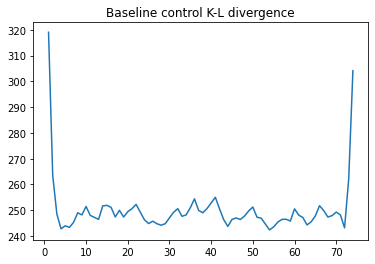

In [441]:
# Need to compute reduced-space form
nEOF = 500
[cer,uce,sce]   = ens.reduce_space(ce,nEOF)

binsize = 3

# Get time-varying reduced-space covariances
#[Cco,tCco]       = ens.mk_covs(cer,np.arange(el),binsize)
#ch = 0
#Cc = Cco[ch:-ch,:,:]
#tCc = tCco[ch:-ch]
[Cc,tCc]       = ens.mk_covs(cer,np.arange(el),binsize)
[tdc,_,_]      = Cc.shape
Cvc            = Cc.reshape(tdc,nEOF**2).T

#cers = cer.transpose(1,0,2).reshape(nEOF,tdn)
#Cmc  = (1/tdn-1)*cers.dot(cers.T)
#Cmc = 1/(999)*np.diag(sce[:nEOF])

Cmc = Cvc.mean(axis=1, keepdims=True).reshape(nEOF,nEOF)
m0 = np.zeros(nEOF)
m1 = np.zeros(nEOF)

kldc = np.empty(tdc)
test = np.random.randn(nEOF,nEOF)
for ii in np.arange(tdc):
    kldc[ii]   = ens.KLdiv(Cc[ii,:,:],Cmc,m0,m1)
    #kldc[ii]   = np.trace(Cc[ii,:,:])
    #kldc[ii]   = ens.KLdiv(Cc[ii,:,:],.0001*test.dot(test.T),m0,m1)
    
plt.plot(tCc,kldc)
plt.title('Baseline control K-L divergence')

## Load LME

In [406]:
out = np.load('input/CESM_LME_all13_wtd_SVD.npz')

u    = out['u']
s    = out['s']
vt   = out['vt']
lat  = out['lat']
lon  = out['lon']
time = out['time']
nt   = out['nt']
nlat = out['nlat']
nlon = out['nlon']
nens = out['nens']

## Compute K-L divergence for LME

In [408]:
binsize = 5

nEOF = 500

# EOF x time*nens
datr = (vt[:nEOF,:]*s[:nEOF,None])

# reshaped into timexEOFxnens
datrr = datr.reshape(nEOF,nt,nens).transpose(1,0,2)

# Get time-varying reduced-space covariances
[C,tC]        = ens.mk_covs(datrr,time,binsize)
[td,_,_]      = C.shape
Cv            = C.reshape(td,nEOF**2).T

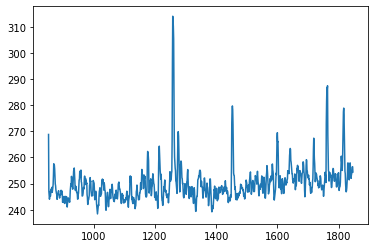

In [409]:

Cm = Cv.mean(axis=1, keepdims=True).reshape(nEOF,nEOF)
m0 = np.zeros(nEOF)
m1 = np.zeros(nEOF)

kld = np.empty(td)
for ii in np.arange(td):
    kld[ii]   = ens.KLdiv(C[ii,:,:],Cm,m0,m1)
    
plt.plot(tC,kld)

## Compute dominant changes to covariance

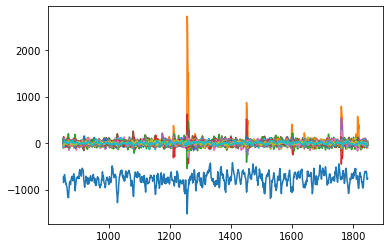

In [459]:
# Remove the time mean covariance
Cnm           = Cv - Cv.mean(axis=0, keepdims=True)
[uC,sC,vCt]   = np.linalg.svd(Cnm, full_matrices=False)

# Plot this many PCs
pltn          = 40

plt.plot(tC,(vCt[:pltn,:]*sC[:pltn,None]).T)

# Plot EOFs of the leading nonstationarity matrix
[uu,ss,_]    = np.linalg.svd(uC[:,0].reshape(nEOF,nEOF),full_matrices=False)

map = u[:,:500].dot(uu[:,0])

plt.matshow(map.reshape([nlat,nlon]))

# Nontrivial to project back into physical space. Will give non-orthogonal patterns. Have to think more.


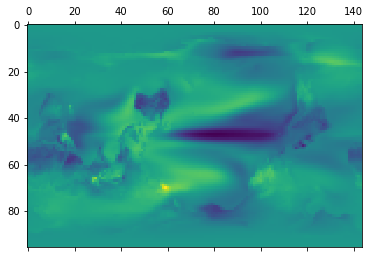

In [468]:
plt.matshow(map.reshape([nlat,nlon]))

In [535]:
# Regress forcing time series onto covariances to obtain patterns of non-stationarity associated with forcing
# Need to get time series of forcing amplitudes (global mean) to do this. I would hypothesize that if we remove the patterns associated with
# these regressions (maybe at some lag?) computed for all forcing time series then we'd get back variability that has K-L divergence indistinguishable from the control run!

#fts = np.random.randn(len(tC))
#proj = Cnm.dot(fts.T)

import csv
#filename = "/Users/damrhein/Downloads/IVI2TotalInjection_501-2000Version2.txt"
#reader = csv.reader(open(filename), delimiter='\t')
#for row in reader:
#    print(row)

import pandas as pd
dataframe = pd.read_fwf(filename,sep=" ", lineterminator='\r',header=8)#colspecs=[(1,14),(15,27)], header=33, dtype="object").astype(float)
dataframe.values.shape

df = pd.read_fwf(filename,header=8)

test = df.valueses[0]
test.strip().split()


ParserError: Error tokenizing data. C error: Expected 14 fields in line 11, saw 32


In [146]:
# debugging mk_covs

data = cer
time = np.arange(el)
binsize = 1

pad                = int(np.floor(binsize/2))
[td,sd,_]          = data.shape

# Define a vector of time indices not in padded regions. These will be our bin centers.
tis                = np.arange(pad,td-pad)
ltis               = len(tis) 

t                  = np.empty(ltis)
C                  = np.empty([ltis,sd,sd])

for ii,ti in enumerate(tis):

    # Define a time range
    tr             = np.arange(ti-pad,ti+pad+1)

    # Select time window
    dat            = data[tr,:,:]

    # Change dimensions of dat from (time, space, nens) to (space,time,nens) to allow for reshaping
    dats         = np.transpose(dat,(1,0,2))
    [sd,td,nd]   = dats.shape

    # Reshape so that the second axis is a combination of time and ensemble dimensions.
    # Default is 'C' indexing which should leave the time dimension intact.
    datr         = dats.reshape((sd,td*nd))

    # Remove the mean over time and ensembles
    datnm        = datr - datr.mean(axis=1, keepdims=True)

    # Save the covariance matrix. Warning -- only do this with reduced space!
    C[ii,:,:] = datnm.dot(datnm.T)

    # Corresponding time
    t[ii]          = time[ti]
